### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('./drive/My Drive/ERA5_Dataset')

FileNotFoundError: [Errno 2] No such file or directory: './drive/My Drive/ERA5_Dataset'

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [ ]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

 # Loading Datasets

In [ ]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ERA5_16zones_avg_std_10D.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

In [ ]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/tc_act_sind.csv')

In [ ]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

In [ ]:
df_target = df_target.rename(columns={'Unnamed: 0': 'DATE'})
df_target = df_target.set_index('DATE')
df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['Label']

df_target

# Compute the compressed representation of the timeseries

In [ ]:
# mjo_encoder  = tfk.models.load_model('./models/XGBoost_MJO_64_ERA5_128/MJO_NINO_ENCODER_64.h5')
# era5_encoder = tfk.models.load_model('./models/XGBoost_MJO_64_ERA5_128/ERA5_ENCODER_128.h5')

mjo_encoder  = tfk.models.load_model('./07_Ensemble_Models/models/MJO_NINO_ENCODER.h5')
era5_encoder = tfk.models.load_model('./07_Ensemble_Models/models/ERA5_ENCODER.h5')

print(mjo_encoder.summary())
print(era5_encoder.summary())

In [ ]:
print(30*9 / 20)
print(11*608 / 512)

In [ ]:
def build_timeseries(X, len_timeseries, N_vars):
  X_timeseries = np.zeros((len(X), len_timeseries, N_vars))
  i = 0

  for elem in X:
    j = 0
    for var_idx in range(N_vars):
        idx = var_idx*len_timeseries
        X_timeseries[i, :, j] = elem[idx : idx + len_timeseries]
        j += 1
    i += 1

  return X_timeseries

In [ ]:
mjo_timeseries  = build_timeseries(df_mjo_enso.values , 30, 9)
era5_timeseries = build_timeseries(df_era5_scaled.values, 11, 2*16*19)

print(mjo_timeseries.shape, era5_timeseries.shape)

In [ ]:
compressed_mjo_timeseries   = mjo_encoder.predict(mjo_timeseries)
compressed_era5_timeseries = era5_encoder.predict(era5_timeseries)

print(compressed_mjo_timeseries.shape, compressed_era5_timeseries.shape)

# Build the dataset to train XGBoost

In [ ]:
era5_columns = df_era5.columns
selected_columns = []

for elem in era5_columns:
  if '-0' in elem:
    selected_columns.append(elem)
df_era5_D0 = df_era5_scaled[selected_columns]

# Create a mapping dictionary for column renaming
column_mapping = {col: col.split('-')[0] if col.endswith('-0') else col for col in df_era5_D0.columns}
# Rename the columns using the mapping dictionary
df_era5_D0.rename(columns=column_mapping, inplace=True)

df_era5_D0

In [ ]:
def build_atts(name, steps):
  new_atts = []
  for i in range(steps):
    new_atts.append('{}_{}'.format(name, i+1))
  return new_atts

compressed_mjo_atts = build_atts('MJO', compressed_mjo_timeseries.shape[1])
compressed_era5_atts = build_atts('ERA5', compressed_era5_timeseries.shape[1])
df_compressed_mjo = pd.DataFrame(compressed_mjo_timeseries, columns = compressed_mjo_atts, index=df_era5.index)
df_compressed_era5 = pd.DataFrame(compressed_era5_timeseries, columns = compressed_era5_atts, index=df_era5.index)

df_compressed_mjo

In [ ]:
df_target[df_target.index > '2012-03-05']

In [ ]:
test_mjo_timeseries  = df_mjo_enso[df_mjo_enso.index > '2012'].values
test_era5_timeseries = df_era5_scaled[df_era5_scaled.index > '2012'].values
test_era5_d0 = df_era5_D0[df_era5_D0.index > '2012'].values
y_test  = df_target[df_target.index > '2012'].values

print(test_mjo_timeseries.shape, test_era5_timeseries.shape, test_era5_d0.shape, y_test.shape)

# np.save('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_mjo_timeseries.npy', test_mjo_timeseries)
# np.save('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_era5_timeseries.npy', test_era5_timeseries)
# np.save('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_era5_d0.npy', test_era5_d0)
# np.save('./07_Ensemble_Models/LIME/LIME_test_sets_D1/y_test.npy', y_test)

In [ ]:
train_mjo_timeseries  = df_mjo_enso[df_mjo_enso.index < '2012'].values
train_era5_timeseries = df_era5_scaled[df_era5_scaled.index < '2012'].values
train_era5_d0 = df_era5_D0[df_era5_D0.index < '2012'].values
y_train  = df_target[df_target.index < '2012'].values

print(train_mjo_timeseries.shape, train_era5_timeseries.shape, train_era5_d0.shape, y_train.shape)

# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_mjo_timeseries.npy', train_mjo_timeseries)
# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_era5_timeseries.npy', train_era5_timeseries)
# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_era5_d0.npy', train_era5_d0)
# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/y_train.npy', y_train)

In [ ]:
era5_d0_features = list(df_era5_D0.columns)
era5_timeseries_features = list(df_era5_scaled.columns)
mjo_enso_timeseries_features = list(df_mjo_enso.columns)

print(era5_d0_features, era5_timeseries_features, mjo_enso_timeseries_features)

In [ ]:
feature_names = era5_d0_features + mjo_enso_timeseries_features + era5_timeseries_features

# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/era5_d0_names.npy', era5_d0_features)
# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/mjo_enso_timeseries_names.npy', mjo_enso_timeseries_features)
# np.save('./07_Ensemble_Models/LIME/LIME_train_sets_D1/era5_timeseries_names.npy', era5_timeseries_features)

In [ ]:
# Consider both the values of variables today and the compressed version of timeseries
merged_df = pd.merge(df_era5_D0, df_compressed_mjo, left_index=True, right_index=True)
merged_df = pd.merge(merged_df, df_compressed_era5, left_index=True, right_index=True)

# Consider only the compressed version of the timeseries for the era5 and mjo-nino datasets
# merged_df = pd.merge(df_compressed_mjo, df_compressed_era5, left_index=True, right_index=True)

merged_df

In [ ]:
from datetime import datetime

def day_of_year(date_string):
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    return date_object.timetuple().tm_yday

# Convert to list of day numbers
day_numbers = [day_of_year(date_str) for date_str in merged_df.index]
merged_df['yday'] = day_numbers

merged_df

## Split in train test sets

In [ ]:
# Split train-test with dates
X_train = merged_df[merged_df.index < '2012'].values
X_test = merged_df[merged_df.index > '2012'].values

y_train = df_target[df_target.index < '2012'].values
y_test  = df_target[df_target.index > '2012'].values

In [ ]:
print('TRAIN SET:        ', X_train.shape, y_train.shape)
print('\nTEST SET :        ', X_test.shape , y_test.shape)

neg_N = y_train.shape[0] - np.count_nonzero(y_train)
pos_N = np.count_nonzero(y_train)

print('POSITIVE SAMPLES: ', pos_N)
print('NEGATIVE SAMPLES: ', neg_N)

neg_pos_ratio = round(neg_N/pos_N, 2)
print('NEG-POS RATIO:    ', neg_pos_ratio)

## Build dataset to predict at d+1, d+2, ..., d+5


In [ ]:
max_lead_time = 10
X_train_future = []
y_train_future = []
X_test_future = []
y_test_future = []

for i in range(max_lead_time):
  X_train_future.append(X_train[:len(X_train)-i])
  y_train_future.append(y_train[i:])
  X_test_future.append(X_test[:len(X_test)-i])
  y_test_future.append(y_test[:len(y_test)-i])
  print('X_train at t+{}:'.format(i+1), X_train_future[i].shape, y_train_future[i].shape)
  print('X_test at t+{} :'.format(i+1), X_test_future[i].shape , y_test_future[i].shape)
  print(X_train_future[i].shape[0] + X_test_future[i].shape[0])
  print('------------------------------------------------')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# HPO and XGBoost Training

## HPO with Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
import sklearn.metrics
import xgboost as xgb
from metrics import TCStats

# HPO with Optuna (HyperParameters Optimization)
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "device": "cuda",
        # scale_pos_weight – Balancing of positive and negative weights.
        'scale_pos_weight': neg_pos_ratio,
        "random_state": 42,

        # use exact for small dataset.
        "tree_method": "hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        #"booster": "dart",
        # L2 regularization weight.
        #"reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        #"reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        #"subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # learning rate
        #"eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "eta": 0.1,
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),

        # n_estimators
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        # max_depth
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        # max_leaves
        "max_leaves": trial.suggest_int("max_leaves", 5, 300),

        # max_bin
        # grow_policy
        #"grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        # min_child_weight
        # max_delta_step
    }

    xgb_classifier = xgb.XGBRFClassifier(**param)
    xgb_classifier.fit(X_train, y_train)
    pred = xgb_classifier.predict(X_test).transpose()
    accuracy = sklearn.metrics.accuracy_score(y_test, pred)
    recall = sklearn.metrics.recall_score(y_test, pred)
    f1 = sklearn.metrics.f1_score(y_test, pred)

    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=4000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-16 13:27:09,541] A new study created in memory with name: no-name-223019fb-7c23-49bb-a33f-87faf839f268
[I 2024-01-16 13:27:18,264] Trial 0 finished with value: 0.6074498567335244 and parameters: {'booster': 'gbtree', 'colsample_bytree': 0.5014788222046135, 'gamma': 0.0001770782884766638, 'n_estimators': 29, 'max_depth': 100, 'max_leaves': 67}. Best is trial 0 with value: 0.6074498567335244.
[I 2024-01-16 13:27:40,454] Trial 1 finished with value: 0.6066024759284732 and parameters: {'booster': 'gbtree', 'colsample_bytree': 0.40193520399279903, 'gamma': 0.04532643376501974, 'n_estimators': 539, 'max_depth': 78, 'max_leaves': 56}. Best is trial 0 with value: 0.6074498567335244.
[I 2024-01-16 13:27:45,939] Trial 2 finished with value: 0.5499103407053197 and parameters: {'booster': 'dart', 'colsample_bytree': 0.22922208773379973, 'gamma': 0.00016023791779626006, 'n_estimators': 242, 'max_depth': 74, 'max_leaves': 18}. Best is trial 0 with value: 0.6074498567335244.
[I 2024-01-16 

Number of finished trials:  100
Best trial:
  Value: 0.6874409820585458
  Params: 
    booster: dart
    colsample_bytree: 0.22024046546134193
    gamma: 0.0010305550828253872
    n_estimators: 468
    max_depth: 83
    max_leaves: 225


## Train the best XGBoost model

In [ ]:
import time

param = trial.params
print(param)
models = []

for i in range(max_lead_time):
  start = time.time()
  print('Training model to predict TC at time t+{} ...'.format(i+1))
  xgb_classifier = xgb.XGBRFClassifier(**param)
  xgb_classifier.fit(X_train_future[i], y_train_future[i])
  models.append(xgb_classifier)
  end = time.time()
  print('Training phase completed')
  print('Training duration: {}'.format(round((end-start))/60))
  print('-----------------------------------------------')

{'booster': 'dart', 'colsample_bytree': 0.22024046546134193, 'gamma': 0.0010305550828253872, 'n_estimators': 468, 'max_depth': 83, 'max_leaves': 225}
Training model to predict TC at time t+1 ...
Training phase completed
Training duration: 6.216666666666667
-----------------------------------------------
Training model to predict TC at time t+2 ...
Training phase completed
Training duration: 6.15
-----------------------------------------------
Training model to predict TC at time t+3 ...
Training phase completed
Training duration: 6.083333333333333
-----------------------------------------------
Training model to predict TC at time t+4 ...
Training phase completed
Training duration: 6.066666666666666
-----------------------------------------------
Training model to predict TC at time t+5 ...
Training phase completed
Training duration: 6.066666666666666
-----------------------------------------------
Training model to predict TC at time t+6 ...
Training phase completed
Training duration:

In [ ]:
# # Save models to files
# for i in range(max_lead_time):
#   pickle.dump(models[i], open("./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/XGBoost_ENS_t+{}.dat".format(i+1), "wb"))

# Evalute models

In [ ]:
models = []
for i in range(max_lead_time):
  models.append(pickle.load(open('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/XGBoost_ENS_t+{}.dat'.format(i+1), "rb")))

In [ ]:
res_train   = []
res_test    = []
predictions = []

for i in range(max_lead_time):
  prediction_train = models[i].predict(X_train_future[i]).transpose()
  d = TCStats(y_train_future[i], prediction_train, y_train_future[0], i+1)
  d = np.array(d)
  res_train.append(d)

  prediction_test = models[i].predict(X_test_future[i]).transpose()
  d = TCStats(y_test_future[i], prediction_test, y_test_future[0], i+1)
  d = np.array(d)
  res_test.append(d)

  predictions.append(prediction_test)

  accuracy = sklearn.metrics.accuracy_score(y_test_future[i], prediction_test)
  recall   = sklearn.metrics.recall_score(y_test_future[i], prediction_test)
  f1       = sklearn.metrics.f1_score(y_test_future[i], prediction_test)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

Evaluation at t+1
ACCURACY:  0.9233506706816316 RECALL:  0.7303149606299213 F1:  0.7260273972602739
------------------------------------------------------
Evaluation at t+2
ACCURACY:  0.913198247535597 RECALL:  0.6850393700787402 F1:  0.6870681145113525
------------------------------------------------------
Evaluation at t+3
ACCURACY:  0.8970145165708026 RECALL:  0.5905511811023622 F1:  0.6147540983606558
------------------------------------------------------
Evaluation at t+4
ACCURACY:  0.8764383561643836 RECALL:  0.4940944881889764 F1:  0.5267576075550893
------------------------------------------------------
Evaluation at t+5
ACCURACY:  0.8646204439572486 RECALL:  0.4271653543307087 F1:  0.4676724137931035
------------------------------------------------------
Evaluation at t+6
ACCURACY:  0.852796052631579 RECALL:  0.35826771653543305 F1:  0.40399556048834623
------------------------------------------------------
Evaluation at t+7
ACCURACY:  0.8524814916369619 RECALL:  0.28740157480

In [ ]:
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_train_d1.npy', X_train_future[0])
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/y_train_d1.npy', y_train_future[0])

# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/X_test_d1.npy', X_test_future[0])
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/y_test_d1.npy', y_test_future[0])

In [ ]:
# np.save('./07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13/feature_names.npy', merged_df.columns)

In [ ]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_train = pd.DataFrame(res_train, columns=headers_list)
df_metrics_train = df_metrics_train.set_index('Window Len')
df_metrics_train

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,1669,1613,0,0,18,1595,74,9970,1.12%,98.88%,99.26%,0.74%,0.9557,0.972,0.0112,0.9557,0.9921
2,1668,1594,0,0,14,1580,88,9974,0.88%,99.12%,99.13%,0.87%,0.9472,0.9687,0.0088,0.9472,0.9912
3,1667,1567,0,0,15,1552,115,9973,0.96%,99.04%,98.86%,1.14%,0.931,0.9598,0.0096,0.931,0.9888
4,1666,1558,0,0,10,1548,118,9978,0.64%,99.36%,98.83%,1.17%,0.9292,0.9603,0.0064,0.9292,0.989
5,1665,1545,0,0,6,1539,126,9982,0.39%,99.61%,98.75%,1.25%,0.9243,0.9589,0.0039,0.9243,0.9887
6,1664,1518,0,0,2,1516,148,9986,0.13%,99.87%,98.54%,1.46%,0.9111,0.9529,0.0013,0.9111,0.9871
7,1663,1539,0,0,2,1537,126,9986,0.13%,99.87%,98.75%,1.25%,0.9242,0.96,0.0013,0.9242,0.989
8,1662,1549,0,0,5,1544,118,9983,0.32%,99.68%,98.83%,1.17%,0.929,0.9617,0.0032,0.929,0.9894
9,1662,1556,0,0,5,1551,111,9982,0.32%,99.68%,98.90%,1.10%,0.9332,0.964,0.0032,0.9332,0.99


In [ ]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_test = pd.DataFrame(res_test, columns=headers_list)
df_metrics_test = df_metrics_test.set_index('Window Len')
df_metrics_test

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,508,514,0,0,143,371,137,3002,27.82%,72.18%,95.64%,4.36%,0.7303,0.726,0.2782,0.7303,0.9234
2,508,505,0,0,157,348,160,2987,31.09%,68.91%,94.92%,5.08%,0.685,0.6871,0.3109,0.685,0.9132
3,508,468,0,0,168,300,208,2975,35.90%,64.10%,93.47%,6.53%,0.5906,0.6148,0.359,0.5906,0.897
4,508,445,0,0,194,251,257,2948,43.60%,56.40%,91.98%,8.02%,0.4941,0.5268,0.436,0.4941,0.8764
5,508,420,0,0,203,217,291,2938,48.33%,51.67%,90.99%,9.01%,0.4272,0.4677,0.4833,0.4272,0.8646
6,508,393,0,0,211,182,326,2929,53.69%,46.31%,89.98%,10.02%,0.3583,0.404,0.5369,0.3583,0.8528
7,508,322,0,0,176,146,362,2963,54.66%,45.34%,89.11%,10.89%,0.2874,0.3518,0.5466,0.2874,0.8525
8,508,259,0,0,153,106,402,2985,59.07%,40.93%,88.13%,11.87%,0.2087,0.2764,0.5907,0.2087,0.8478
9,508,210,0,0,133,77,431,3004,63.33%,36.67%,87.45%,12.55%,0.1516,0.2145,0.6333,0.1516,0.8453


In [ ]:
import numpy as np

def brier_skill_score(y_true, y_prob):
    """
    Calculate Brier Skill Score.

    Parameters:
    - y_true: numpy array or pandas Series, true binary labels (0 or 1).
    - y_prob: numpy array or pandas Series, predicted probabilities for the positive class.

    Returns:
    - Brier Skill Score
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Brier Score for the model (predicted probabilities)
    brier_model = np.mean((y_true - y_prob)**2)

    # Brier Score for the climatology (mean of true labels)
    brier_climatology = np.mean((y_true - np.mean(y_true))**2)

    # Brier Skill Score
    brier_skill_score = 1 - (brier_model / brier_climatology)

    return brier_skill_score


bss = []
for i in range(max_lead_time):
  bss.append(brier_skill_score(y_test_future[i], predictions[i]))
  print('BRIER SKILL SCORE AT t+{}: '.format(i+1), brier_skill_score(y_test_future[i], predictions[i]))

BRIER SKILL SCORE AT t+1:  0.3597886909605299
BRIER SKILL SCORE AT t+2:  0.27515727995832573
BRIER SKILL SCORE AT t+3:  0.14021159381803328
BRIER SKILL SCORE AT t+4:  -0.031334422630653114
BRIER SKILL SCORE AT t+5:  -0.12971569814518147
BRIER SKILL SCORE AT t+6:  -0.22810572245348304
BRIER SKILL SCORE AT t+7:  -0.23044728121950664
BRIER SKILL SCORE AT t+8:  -0.26938392978124415
BRIER SKILL SCORE AT t+9:  -0.2900258283780832
BRIER SKILL SCORE AT t+10:  -0.2626345813916118


## Plot results

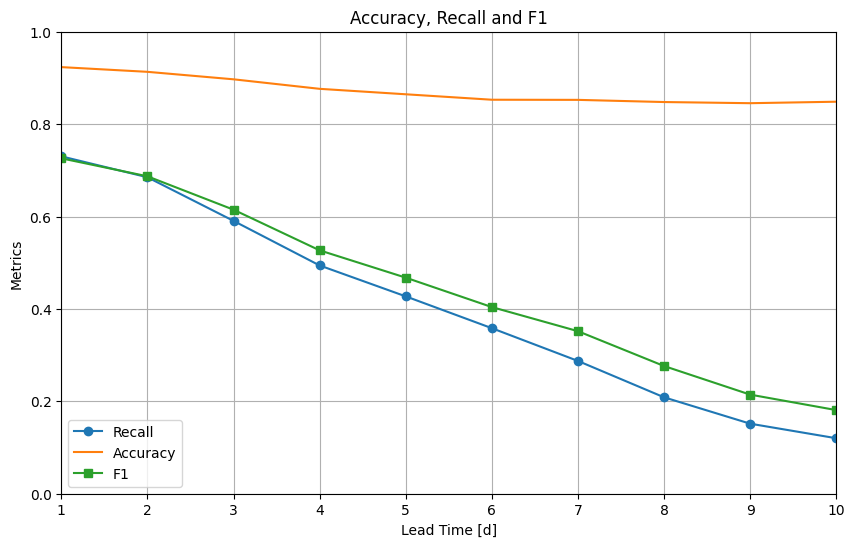

In [ ]:
test_pod = df_metrics_test['POD'].values.astype(float)
test_acc = df_metrics_test['Accuracy'].values.astype(float)
test_f1 = df_metrics_test['F1'].values.astype(float)
test_far = df_metrics_test['False Alarm Ratio'].values.astype(float)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, test_pod, label='Recall', marker='o')
# Plotting Accuracy
plt.plot(x, test_acc, label='Accuracy')
# Plotting F1
plt.plot(x, test_f1, label='F1', marker='s')
# Plotting FAR
#plt.plot(x, test_far, label='FAR', marker='^')

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [d]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
bss_perc = [elem*100 for elem in bss]

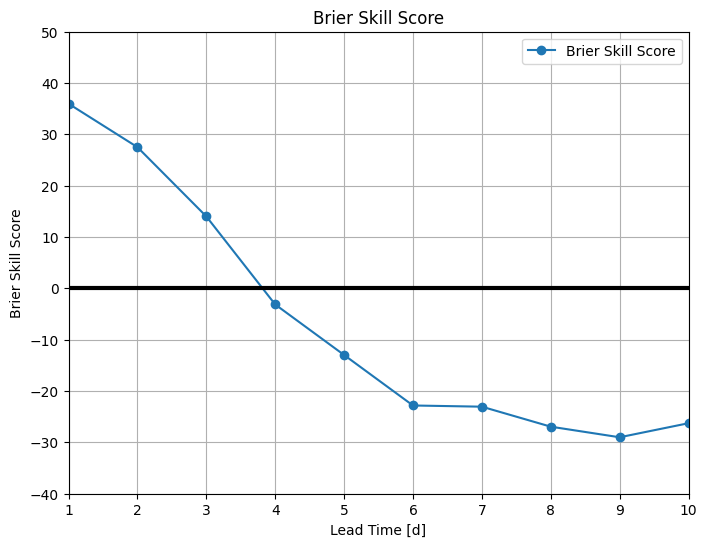

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(8, 6))  # Adjust width and height as needed
# Plotting BSS
plt.plot(x, bss_perc, label='Brier Skill Score', marker='o')

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(-40, 50)  # Adjust the range based on your data
plt.xticks(x)

plt.axhline(y=0, color='black', linewidth=3)
# Adding labels and title
plt.xlabel('Lead Time [d]')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Score')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()